In [2]:
from scipy.integrate import quad

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from geopandas.tools import sjoin
import shapely
from shapely.geometry import Point
import pyreadr
import mercantile
from shapely.geometry import shape
import networkx as nx
import seaborn as sn
import pickle
import scipy.sparse as sp
from scipy.optimize import least_squares
import datetime
import lmfit
from sklearn import metrics
from scipy.integrate import odeint
import statsmodels.api as sm

In [3]:
pip install lmfit

Note: you may need to restart the kernel to use updated packages.


# Generation of timeseries of networks for daily mobility flows

## Import data and preprocessing

In [4]:
###############
# Import data #
###############

root_data = '/Users/ignaciosacristanbarba/Documents/M4R/Data'


# Reads in the timeseries of between tiles movement data
root1 = root_data+'/BETWEEN_TILES_TRIP_NUMBERS.csv'
df = pd.read_csv(root1)

#####################
# Load LSCC DiGraph #
#####################

# Load LSCC 
root_results = '/Users/ignaciosacristanbarba/Documents/M4R/Results' 
root_Base = root_results+'/Base Network/'
root2 = root_Base+'/base_network_lscc.npz'

with open(root2, 'rb') as handle:
    lscc_dict = pickle.load(handle)
        
# Generate DiGraph from data 
lscc = nx.from_dict_of_dicts(lscc_dict,create_using = nx.DiGraph)
lscc_nodes = list(lscc.nodes())
n_nodes = len(lscc_nodes)
num_to_nodes = {i: lscc_nodes[i] for i in range(n_nodes)}

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)

########################
# Load D_geom for LSCC #
########################

root_D_geom = root_Base + '/lscc_D_geom.pickle'
with open(root_D_geom, 'rb') as handle:
        D_geom = pickle.load(handle)

###########################
# Get dates of timeseries #
###########################

# Get start and end dates
start_date = df.columns.values[2][:10]
end_date = df.columns.values[-1][:10]

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date
n_days = len(days)
days_dm = np.asarray([str(days[i])[5:] for i in range(n_days)])
days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
weeks = np.arange(days_week.min(),days_week.max())

# Indicate weekdays
weekday = pd.date_range(start=start_date, end=end_date).weekday<5

# Consider bank holidays
bank_holidays = []
bank_holidays.append(np.argwhere(days==datetime.date(2020, 4, 10))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 4, 13))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 5, 8))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 5, 25))[0][0])
weekday[bank_holidays] = False


# Store lockdown-date
lockdown_date = pd.to_datetime('20200324', format='%Y%m%d', errors='ignore')
lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]
lockdown_week = lockdown_date.week

# Store date information
timestamps = {'days' : days, 'weekdays' : weekday, 'weeks' : weeks, 
              'lockdown_day' : lockdown_date}

root_results_timeseries = '/Users/ignaciosacristanbarba/Documents/M4R/Results'+'/Timeseries/'
root3 = root_results_timeseries+'timestamps.pkl'

# Store second lockdown-date
second_lockdown_date = pd.to_datetime('20201105', format='%Y%m%d', errors='ignore')
second_lockdown_date_number = np.argwhere(days == second_lockdown_date).flatten()[0]

# Store data (serialize)
with open(root3, 'wb') as handle:
    pickle.dump(timestamps, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Generation of daily DiGraphs

Generate network for each day by summing over all hours per day. 

In [5]:
# root to store results in this section
root_results_timeseries = root_results+'/Timeseries/'

In [6]:
def rewire_graph(G):
    '''
    Permute nodes in datastructure such that G.nodes() == lscc.nodes()
    '''
    n_nodes = len(G.nodes())
    G_dict = nx.to_dict_of_dicts(G)
    new_dict = {list(lscc_dict.keys())[i] : G_dict[list(lscc_dict.keys())[i]] for i in range(n_nodes)}
    G_new = nx.from_dict_of_dicts(new_dict, create_using = nx.DiGraph)
    
    return G_new

In [7]:
#compute the daily digraphs
compute_again = False

if compute_again == True:
    
    # Converting the quadkeys to strings
    df['start_quadkey'] = df['start_quadkey'].astype(str)
    df['end_quadkey'] = df['end_quadkey'].astype(str)
    # adding a leading '0' to quadkeys beginning with 3 so it maps on to web mercator
    df.loc[df['start_quadkey'].str[:1] == '3', 'start_quadkey'] = '0'+df['start_quadkey']
    df.loc[df['end_quadkey'].str[:1] == '3', 'end_quadkey'] = '0'+df['end_quadkey']

    # Replace nan by 0
    df = df.fillna(0)
    
    ###################################
    # Filtering out rows outside LSCC #
    ###################################

    # Get LSCC quadkeys
    quadkeys_timeseries_LSCC = set(lscc_dict.keys())

    df_filtered = df.copy()

    for i in range(df.shape[0]):

        start_included =  df.iloc[i]['start_quadkey'] in quadkeys_timeseries_LSCC
        end_included = df.iloc[i]['end_quadkey'] in quadkeys_timeseries_LSCC 
        included = start_included + end_included

        if included != 2:
            df_filtered = df_filtered.drop([i])

    print('Number of deleted rows:', df.shape[0] - df_filtered.shape[0])

    df = df_filtered.reset_index(drop=True)
    
    #####################################
    # Generate daily DiGraphs from data #
    #####################################

    # Get the first two quadkey columns
    df_key = df.iloc[:,:2]

    M = df.shape[1]-3
    networks = []

    for i in range(1,M,3):

        # Get daily data 
        df_mov = df.iloc[:,i+1:i+4]
        df_sum = pd.Series(df_mov.sum(axis=1),name='movement')
        df_sum = pd.concat([df_key,df_sum],axis=1)

        # Generate DiGraph 
        N = len(df_sum)
        G = nx.DiGraph()
        # for each row, add nodes and weighted edge
        for j in range(0,N):
            start = df_sum['start_quadkey'][j]
            end = df_sum['end_quadkey'][j]
            weight = df_sum['movement'][j]
            G.add_node(start)
            G.add_node(end)
            if weight > 0.0:
                G.add_weighted_edges_from([(start, end, weight)] )

        # Append DiGraph to list of networks
        networks.append(G)

    ###########################################
    # Permute nodes such that they match LSCC #
    ###########################################

    for i in range(len(networks)):
        networks[i] = rewire_graph(networks[i])
        
    ########################
    # Store daily DiGraphs #
    ########################

    root4 = root_results_timeseries+'timeseries_daily_digraphs_lscc.pkl'

    # Store data (serialize)
    with open(root4, 'wb') as handle:
        pickle.dump(networks, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
# Load networks      
else: 
    
    root4 = root_results_timeseries+'timeseries_daily_digraphs_lscc.pkl'
    with open(root4, 'rb') as handle:
        networks = pickle.load(handle)
        
##############################
# Compute adjacency matrices #
##############################

n_networks = len(networks)
networks_adjacency = [nx.adjacency_matrix(networks[i]) for i in range(n_networks)]
        

#####################
# Compute geography #
#####################

# add polygons as node attributes
G = networks[0]
quadkeys = list(G.nodes)
n_nodes = len(quadkeys)

polys = []

#Iterates over the quadkeys to extract the tiles
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))

geom = [shape(i) for i in polys]
geom_dict = {quadkeys[i] : list(geom[i].centroid.bounds[:2]) for i in range(0,n_nodes)}

n_networks = len(networks)

for i in range(0,n_days):
    G = networks[i]
    nx.set_node_attributes(G,geom_dict,'geom')

# Store node keys
node_numbers = {i : list(networks[0].nodes())[i] for i in range(n_nodes)}
# Gemo dicy for node keys
geom_dict_numbers = {i : geom_dict[node_numbers[i]] for i in range(n_nodes)}    

In [8]:
root_figure = '/Users/ignaciosacristanbarba/Documents/M4R/Figures/'

# Visualisation of daily DiGraphs

In [9]:
# root to store figures on the lscc timeseries 
root_figures_timeseries_lscc = root_figure + 'Timeseries_lscc'

In [10]:
#choose dates to visualize
sample_wednesdays = [0,22,113,260]
sample_wedesdays_names = [r'Weds $10^{th}$ March',r'Weds $1^{st}$ April', r'Weds $1^{st}$ July',r'Weds $25^{th}$ November']
sample_sundays = [5,26,117,264]
sample_sundays_names = [r'Sun $14^{th}$ March',r'Sun $5^{th}$ April', r'Sun $5^{th}$ July',r'Sun $29^{th}$ November']

In [11]:
from matplotlib.colors import ListedColormap
newcmp = ListedColormap(['grey','b','forestgreen'])

def visualse_largest_components(G):
    '''
    input: network G
    output: function computed indicator for nodes in LSCC and LWCC
    '''
    
    node_dict = {list(G.nodes)[i] : i for i in range(n_nodes)}
    
    # Compute weakly connected components of G
    wcc_set = list(nx.weakly_connected_components(G))
    n_wcc = len(list(wcc_set))

    # Store component label for each node in G
    wcc_id = np.zeros(n_nodes,dtype=int)

    # Repeat for each community k
    for k in range (0,n_wcc):
        # Nodes of the k-th component are marked with k
        nodes = list(wcc_set[k])
        for node in nodes:
            wcc_id [node_dict[node]]=k

    # Compute sizes of each component
    unordered_counts = np.histogram(wcc_id,bins=np.arange(0,n_wcc+1)) [0]
    # Get component indices sorted according to size
    component_ranked = np.argsort(-unordered_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {component_ranked[k] : k for k in range(0,n_wcc)}
    # Apply permutation to labels
    wcc_id_ranked = wcc_id.copy()
    for i in range (0,len(wcc_id_ranked)):
        wcc_id_ranked[i] = rank[wcc_id_ranked[i]]
    
    # Get indicator for LWCC
    ind_lwcc = np.asarray(wcc_id_ranked == 0, dtype = 'int')
    
    # Compute strongly connected comoonents of G
    scc_set = list(nx.strongly_connected_components(G))
    n_scc = len(list(scc_set))

    # Store component label for each node in G
    scc_id = np.zeros(n_nodes,dtype=int)

    # Repeat for each community k
    for k in range (0,n_scc):
        # Nodes of the k-th component are marked with k
        nodes = list(scc_set[k])
        for node in nodes:
            scc_id [node_dict[node]]=k

    # Compute sizes of each component
    unordered_counts = np.histogram(scc_id,bins=np.arange(0,n_scc+1)) [0]
    # Get component indices sorted according to size
    component_ranked = np.argsort(-unordered_counts)
    # Create dictionary that describes map from old labels to new labels
    rank = {component_ranked[k] : k for k in range(0,n_scc)}
    # Apply permutation to labels
    scc_id_ranked = scc_id.copy()
    for i in range (0,len(scc_id_ranked)):
        scc_id_ranked[i] = rank[scc_id_ranked[i]]
        
    ind_lscc = np.asarray(scc_id_ranked == 0, dtype = 'int')
    
    return ind_lwcc + ind_lscc

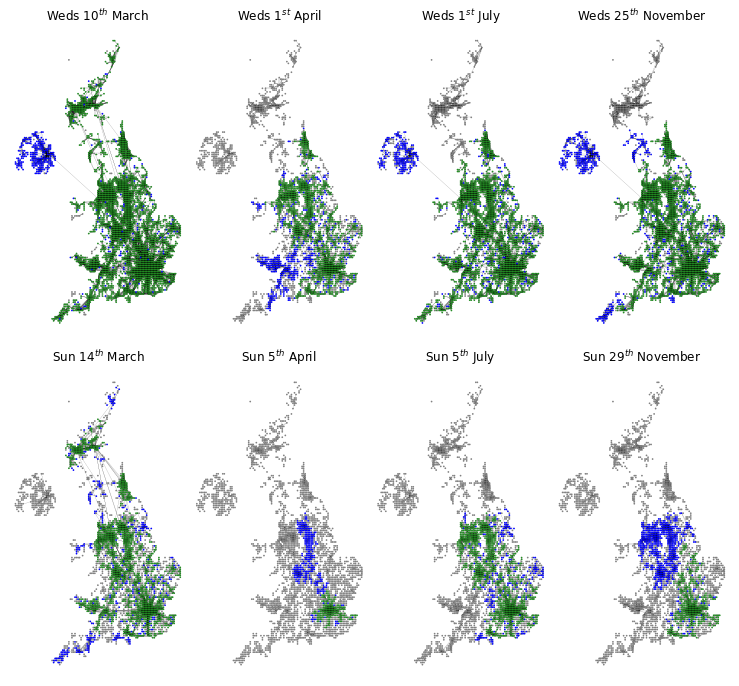

In [12]:
#plot on those dates

fig, axes = plt.subplots(2, 4, figsize=(13,12))
fig.subplots_adjust(hspace=0.1, wspace=0)

for i, ax in enumerate(axes.flat):
    
    # Get network for day
    if i<4:
        day = sample_wednesdays[i]
        ax.set(title = sample_wedesdays_names[i])
    else:
        day = sample_sundays[i-4]
        ax.set(title = sample_sundays_names[i-4])
    
    # Get network
    G = networks[day]
    
    # Plot
    nx.draw(G, ax=ax,pos=geom_dict,node_size=0.5, width = 0.1,  arrows=False,
           node_color = visualse_largest_components(G), cmap = newcmp)
   
    
plt.show()
fig.savefig(root_figures_timeseries_lscc+'/Samples.eps', dpi=fig.dpi,bbox_inches='tight')

# Descriptive statistics for daily DiGraphs

## Define selection of  model function

In [14]:
def select_model(feature,base_value,name=None):
    '''
    input: time series and baseline value
    output: the response function is fitted to the normalised time series and optimal response parameters
            and CIs are returned with a model quality assesment
    '''
    
    ################
    # Select Model #
    ################
    
    # Compute MM
    signal = pd.Series(pd.Series(feature/base_value))
    
    signal_mm = np.roll(np.asarray(signal.rolling(window = 7, win_type='triang').mean()),-3)
    x_mm = np.arange(len(signal))[np.nan_to_num(signal_mm)>0]
    signal_mm = signal_mm[np.nan_to_num(signal_mm)>0]
    
    # Compute AIC for m=0
    params['m'].vary = False
    
    ls1 = mod.fit(signal_mm, params, x=x_mm)
    
    bic1 = ls1.bic
    aic1 = ls1.aic
    params['m'].vary = True
    
    # Compute AIC for m!=0
    ls2 = mod.fit(signal_mm, params, x=x_mm)
    bic2 = ls2.bic
    aic2 = ls2.aic
    
    # Compute DeltaBIC
    delta_bic = bic1-bic2
    
    if delta_bic > 0:
        ls = ls2
    else:
        ls = ls1
                           
    ### Add model selection criteria and print them ####
    
    #Add CVRMSE
    result_string = str(name) + ' & '+'CVRMSE = '
    signal_mean = np.mean(signal)
    prediction = ls.eval(ls.params, x=np.arange(len(signal)))
    CVRMSE = np.sqrt(metrics.mean_absolute_error(signal,prediction))/signal_mean
    result_string+=str(np.around(CVRMSE,3))
        
    # Add BIC
    result_string+= '& BIC= ' + str(np.around(bic1,1))+ ' and ' + str(np.around(bic2,1))
    
    result_string+= '& AIC= ' + str(np.around(aic1,1))+ ' and ' +str(np.around(aic2,1))
    # Print report 
    print(result_string+'\n')
    
    return ls
    
        
    

# Symmetric vs Asymmetric

# Asymmetric

In [15]:
#define asymmetric response function
def response_asymetric_laplacian(x, alpha,beta,lamb1a,lamb1b,lamb2a,lamb2b,t1,t2, m):
    #this is just the definition of the analytic solution of the asymmetric laplacian with two stimuli in the report.
    y = np.zeros(len(x)) 
    t1 = t1*x[-1]/100
    t2 = t2*x[-1]/100

    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1a)*(np.exp(lamb1a*(s-t1))-np.exp(-beta*s-lamb1a*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1a)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1a*t1))+
                     alpha/(beta-lamb1b)*(np.exp(-lamb1b*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2a)*(np.exp(lamb2a*(s-t2))-np.exp(-beta*s-lamb2a*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2a)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2a*t2))+
                     alpha/(beta-lamb2b)*(np.exp(-lamb2b*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)

# Define model
mod = lmfit.Model(response_asymetric_laplacian)
# Define parameters
params = lmfit.Parameters()
params.add('alpha', value=1)
params.add('beta', value=0.01, min=0.00001)
params.add('lamb1a', value=0.1, min=0.00001)
params.add('lamb1b', value=0.3, min=0.00001)
params.add('lamb2a', value=0.1, min=0.00001)
params.add('lamb2b', value=0.3, min=0.00001)
params.add('t1', value=5,min = 0)
params.add('t2', value=96)
params.add('m', value=0)

## Number of trips

In [16]:
compute_trips_again = False

if compute_trips_again == True:
    n_total = []
    n_total_inter = []
    n_total_intra = []
    for A in networks_adjacency:
        intra = np.diag(np.diag(A.toarray()))
        B = A - intra
        n_total.append(np.sum(A))
        n_total_inter.append(np.sum(B))
        n_total_intra.append(np.sum(intra))

    results = pd.DataFrame({'day':days, 'n_total': n_total, 
                            'n_total_inter' : n_total_inter, 
                            'n_total_intra':n_total_intra})
    
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results.to_csv(root3)
    
else:
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results = pd.read_csv(root3)
    

In [17]:
n_total_lscc = np.sum(A_LSCC)
intra_LSCC = np.diag(np.diag(A_LSCC.toarray()))
n_total_intra_lscc = np.sum(intra_LSCC)
B_LSCC = A_LSCC - intra_LSCC
n_total_inter_lscc = np.sum(B_LSCC)

n_total & CVRMSE = 0.113& BIC= -1944.3 and -2237.0& AIC= -1972.8 and -2269.1

n_total_inter & CVRMSE = 0.634& BIC= -1497.6 and -1581.0& AIC= -1526.1 and -1613.0

n_total_intra & CVRMSE = 0.128& BIC= -2115.0 and -2229.5& AIC= -2143.5 and -2261.5



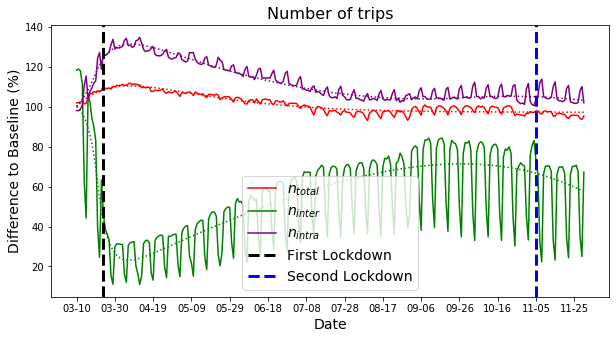

In [18]:
### fit the three different types of trips and plot

########################
ls_n_total = select_model(results['n_total'],n_total_lscc,'n_total')

##############################
# Fit model to n_total_inter #
##############################

ls_n_total_inter = select_model(results['n_total_inter'],n_total_inter_lscc,'n_total_inter')

##############################
# Fit model to n_total_intra #
##############################

ls_n_total_intra = select_model(results['n_total_intra'],n_total_intra_lscc,'n_total_intra')

# ##############
# Plot curves #
# ##############

x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))

ax.plot(100*results['n_total']/n_total_lscc,label=r'$n_{total}$',color = 'red')
ax.plot(x_days, 100*ls_n_total.eval(ls_n_total.params, x=x_days),linestyle = ':', color = 'red')
ax.plot(100*results['n_total_inter']/n_total_inter_lscc,label=r'$n_{inter}$',color='green')
ax.plot(x_days, 100*ls_n_total_inter.eval(ls_n_total_inter.params, x=x_days),linestyle = ':', color = 'green')
ax.plot(100*results['n_total_intra']/n_total_intra_lscc,label=r'$n_{intra}$',color='purple')
ax.plot(x_days, 100*ls_n_total_intra.eval(ls_n_total_intra.params, x=x_days),linestyle = ':', color = 'purple')
ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Number of trips',fontsize = 16)
ax.legend(loc=8,frameon = True,fontsize =14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/days_trips_asymmetric.pdf', dpi=fig.dpi,bbox_inches='tight')

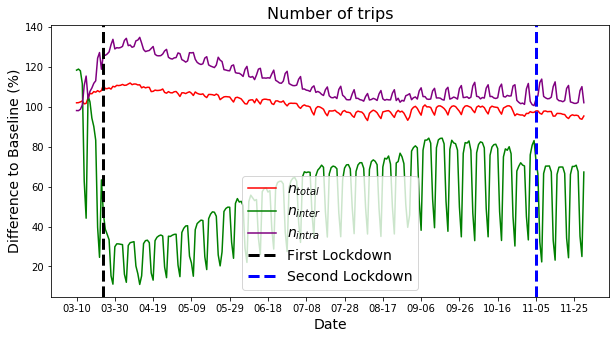

In [19]:
#plot without the fit
fig, ax = plt.subplots(1,figsize =(10,5))

ax.plot(100*results['n_total']/n_total_lscc,label=r'$n_{total}$',color = 'red')
ax.plot(100*results['n_total_inter']/n_total_inter_lscc,label=r'$n_{inter}$',color='green')
ax.plot(100*results['n_total_intra']/n_total_intra_lscc,label=r'$n_{intra}$',color='purple')
ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Number of trips',fontsize = 16)
ax.legend(loc=8,frameon = True,fontsize =14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/no_model_days_trips.pdf', dpi=fig.dpi,bbox_inches='tight')

In [20]:
#print parameters
ls_n_total.params

name,value,initial value,min,max,vary
alpha,0.01053976,1,-inf,inf,True
beta,0.03268779,0.01,1.0000e-05,inf,True
lamb1a,0.06983947,0.1,1.0000e-05,inf,True
lamb1b,0.03268410,0.3,1.0000e-05,inf,True
lamb2a,0.34231800,0.1,1.0000e-05,inf,True
lamb2b,1.14787243,0.3,1.0000e-05,inf,True
t1,0.24646552,5,0.00000000,inf,True
t2,111.195431,96,-inf,inf,True
m,-0.08883962,0,-inf,inf,True


In [21]:
#print parameters
ls_n_total_inter

In [22]:
#print parameters
ls_n_total_intra.params

name,value,standard error,relative error,initial value,min,max,vary
alpha,0.02799939,0.00237870,(8.50%),1,-inf,inf,True
beta,1.0020e-05,4.4375e-06,(44.29%),0.01,1.0000e-05,inf,True
lamb1a,0.06053548,0.02986969,(49.34%),0.1,1.0000e-05,inf,True
lamb1b,0.10540229,0.00702301,(6.66%),0.3,1.0000e-05,inf,True
lamb2a,0.00101879,9.8069e-05,(9.63%),0.1,1.0000e-05,inf,True
lamb2b,9.7168e-04,3.4250e-04,(35.25%),0.3,1.0000e-05,inf,True
t1,3.69585737,0.48096399,(13.01%),5,0.00000000,inf,True
t2,76.6537751,2.12442346,(2.77%),96,-inf,inf,True
m,-0.97840797,0.00442323,(0.45%),0,-inf,inf,True


## Size of connected components

In [23]:
compute_n_components_again = False
if compute_n_components_again == True:
    n_nodes = len(networks[0].nodes)

    # Compute number of WCCs, SCCs and size of LWCC, LSCC
    n_wcc = []
    s_lwcc = []
    n_scc = []
    s_lscc = []

    for G in networks:
        n_wcc.append(nx.algorithms.components.number_weakly_connected_components(G))
        s_lwcc.append(len(max(nx.algorithms.components.weakly_connected_components(G), key=len)))
        n_scc.append(nx.algorithms.components.number_strongly_connected_components(G))
        s_lscc.append(len(max(nx.algorithms.components.strongly_connected_components(G), key=len)))

    # Store results in dataframe
    results['n_wcc'] = n_wcc
    results['s_lwcc'] = s_lwcc
    results['n_scc'] = n_scc
    results['s_lscc'] = s_lscc
    
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results.to_csv(root3)
    
else:
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results = pd.read_csv(root3)
    


In [24]:
# Compute baseline values
n_wcc_lscc = nx.algorithms.components.number_weakly_connected_components(lscc)
s_lwcc_lscc = len(max(nx.algorithms.components.weakly_connected_components(lscc), key=len))
n_scc_lscc = nx.algorithms.components.number_strongly_connected_components(lscc)
s_lscc_lscc = len(max(nx.algorithms.components.strongly_connected_components(lscc), key=len))

s_lwcc & CVRMSE = 0.531& BIC= -1536.9 and -1536.2& AIC= -1565.4 and -1568.3

s_lscc & CVRMSE = 0.653& BIC= -1483.7 and -1562.9& AIC= -1512.2 and -1595.0



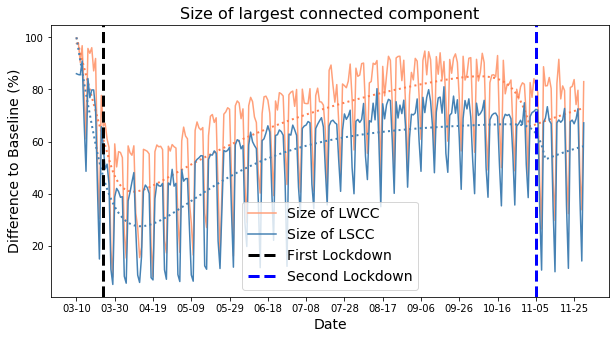

In [26]:
#######################
# Fit model to s_lwcc #
#######################

ls_s_lwcc = select_model(results['s_lwcc'],s_lwcc_lscc,'s_lwcc')
    
#######################
# Fit model to s_lscc #
#######################

ls_s_lscc = select_model(results['s_lscc'],s_lwcc_lscc,'s_lscc')


###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*results['s_lwcc']/s_lwcc_lscc,label='Size of LWCC',color = 'lightsalmon')
ax.plot(x_days, 100*ls_s_lwcc.eval(ls_s_lwcc.params, x=x_days),linestyle = ':', color = 'coral',linewidth=2)
ax.plot(100*results['s_lscc']/s_lscc_lscc,label='Size of LSCC',color = 'steelblue')
ax.plot(x_days, 100*ls_s_lscc.eval(ls_s_lscc.params, x=x_days),linestyle = ':', color = 'steelblue',linewidth=2)
ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Size of largest connected component',fontsize = 16)
ax.legend(loc=8,frameon = True,fontsize = 14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/s_components_asymmetric.pdf', dpi=fig.dpi,bbox_inches='tight')

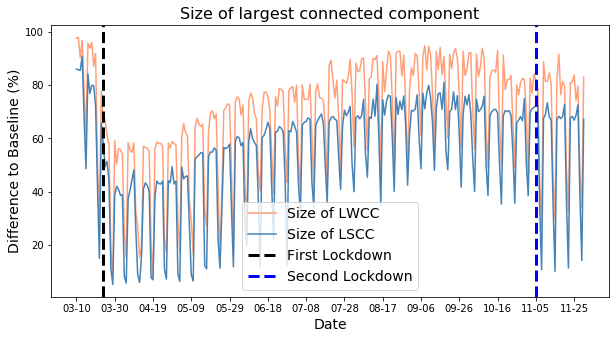

In [27]:
# plot without fit
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*results['s_lwcc']/s_lwcc_lscc,label='Size of LWCC',color = 'lightsalmon')
ax.plot(100*results['s_lscc']/s_lscc_lscc,label='Size of LSCC',color = 'steelblue')
ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Size of largest connected component',fontsize = 16)
ax.legend(loc=8,frameon = True,fontsize = 14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/no_model_s_components.pdf', dpi=fig.dpi,bbox_inches='tight')

In [28]:
#print model for size of LWCC
ls_s_lwcc

In [29]:
#print model for size of LSCC
ls_s_lscc

## Radius of gyration

radius_of_gyration & CVRMSE = 0.479& BIC= -1617.2 and -1633.6& AIC= -1645.7 and -1665.7



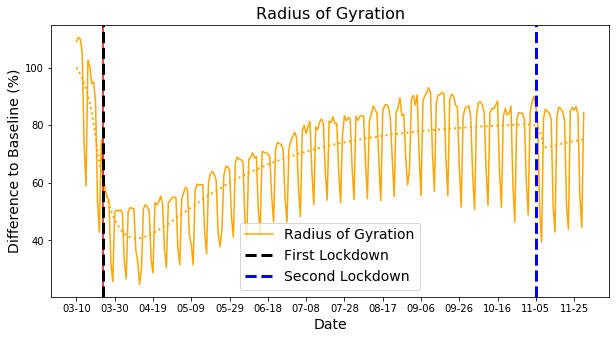

In [30]:
# import the csv with the RoG results 
r_inter_median = pd.read_csv(root_results+'/r_inter_median.csv',index_col=0)
r_inter_median_lscc = 2473.306510441376 #baseline value
r_inter_median =r_inter_median.iloc[:,0]

#######################
# Fit model to s_lwcc #
#######################

ls_r_inter_median = select_model(r_inter_median,r_inter_median_lscc,'radius_of_gyration')
  
###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*r_inter_median/r_inter_median_lscc,label='Radius of Gyration',color = 'orange')
ax.plot(x_days, 100*ls_r_inter_median.eval(ls_r_inter_median.params, x=x_days),linestyle = ':', color = 'orange',linewidth=2)

ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number, color = 'red')
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
       
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Radius of Gyration',fontsize = 16)

ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.legend(loc=8,frameon = True,fontsize = 14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/rad_gyration_asymmetrix.pdf', dpi=fig.dpi,bbox_inches='tight')

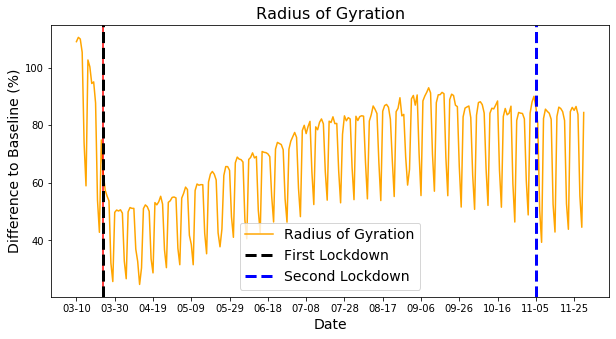

In [31]:
#plot without the fit

fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*r_inter_median/r_inter_median_lscc,label='Radius of Gyration',color = 'orange')


ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number, color = 'red')
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
       
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Radius of Gyration',fontsize = 16)

ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.legend(loc=8,frameon = True,fontsize = 14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/no_model_rad_gyration.pdf', dpi=fig.dpi,bbox_inches='tight')

In [32]:
#print the model
ls_r_inter_median

## Degree

degree & CVRMSE = 0.582& BIC= -1534.3 and -1615.1& AIC= -1562.8 and -1647.1



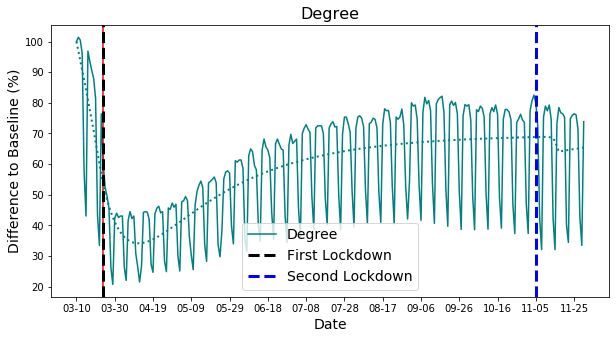

In [33]:
# import csv where we stored the degree results
degree_median_df = pd.read_csv(root_results+'/degree_median.csv',index_col=0) 

degree_median = degree_median_df.iloc[:,0]
degree_median_base = degree_median[0]

##### Fit median of degree #####

ls_degree_median = select_model(degree_median,degree_median_base,'degree')
  
###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*degree_median/degree_median_base,label='Degree',color = 'teal')
ax.plot(x_days, 100*ls_degree_median.eval(ls_degree_median.params, x=x_days),linestyle = ':', color = 'teal',linewidth=2)
ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number, color = 'red')
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Degree',fontsize = 16)

ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.legend(loc=8,frameon = True,fontsize = 14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/degree_asymmetric.pdf', dpi=fig.dpi,bbox_inches='tight')

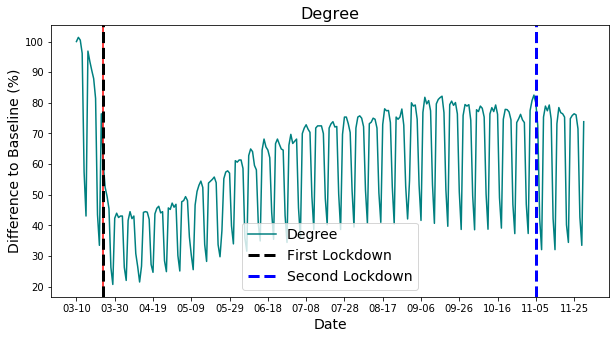

In [34]:
# plot without the fit 

fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*degree_median/degree_median_base,label='Degree',color = 'teal')
ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number, color = 'red')
ax.set(xticks = ticks, xticklabels = days_dm[ticks])
ax.set_ylabel('Difference to Baseline (%)',fontsize = 14)
ax.set_xlabel('Date',fontsize = 14)
ax.set_title('Degree',fontsize = 16)


ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.legend(loc=8,frameon = True,fontsize = 14)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/no_model_degree.pdf', dpi=fig.dpi,bbox_inches='tight')

In [35]:
#print model
ls_degree_median

# Symmetric

In [36]:
#define model now with the symmetric Laplacian structure

def response_laplacian(x, alpha,beta,lamb1,lamb2,t1,t2, m):
    y = np.zeros(len(x))
    t1 = t1*x[-1]/100
    t2 = t2*x[-1]/100
    
    for i,s in enumerate(x):
        if s <= t1:
             y[i] = (1+m*alpha/beta*(1-np.exp(-beta*s))+alpha/(beta+lamb1)*(np.exp(lamb1*(s-t1))-np.exp(-beta*s-lamb1*t1)))
        else:
             y[i] =(1+m*alpha/beta*(1-np.exp(-beta*s))+
                     alpha/(beta+lamb1)*(np.exp(-beta*(s-t1))-np.exp(-beta*s-lamb1*t1))+
                     alpha/(beta-lamb1)*(np.exp(-lamb1*(s-t1))-np.exp(-beta*(s-t1))))
        if s<=t2:
            y[i] += (alpha/(beta+lamb2)*(np.exp(lamb2*(s-t2))-np.exp(-beta*s-lamb2*t2)))
        else:
            y[i] +=(alpha/(beta+lamb2)*(np.exp(-beta*(s-t2))-np.exp(-beta*s-lamb2*t2))+
                     alpha/(beta-lamb2)*(np.exp(-lamb2*(s-t2))-np.exp(-beta*(s-t2))))
    return np.nan_to_num(y)

#define model
mod = lmfit.Model(response_laplacian)

# Define parameters
params = lmfit.Parameters()
params.add('alpha', value=1)
#params.add('alpha1', value=1)
#params.add('alpha2', value=1)
params.add('beta', value=0.01, min=0.00001)
#params.add('beta1', value=0.01, min=0.00001)
#params.add('beta2', value=0.01, min=0.00001)
#params.add('lamb', value=0.1, min=0.00001)
params.add('lamb1', value=0.1, min=0.00001)
params.add('lamb2', value=0.3, min=0.00001)
params.add('t1', value=5)
params.add('t2', value=98)
params.add('m', value=0)

## Number of trips

In [37]:
compute_trips_again = False

if compute_trips_again == True:
    n_total = []
    n_total_inter = []
    n_total_intra = []
    for A in networks_adjacency:
        intra = np.diag(np.diag(A.toarray()))
        B = A - intra
        n_total.append(np.sum(A))
        n_total_inter.append(np.sum(B))
        n_total_intra.append(np.sum(intra))

    results = pd.DataFrame({'day':days, 'n_total': n_total, 
                            'n_total_inter' : n_total_inter, 
                            'n_total_intra':n_total_intra})
    
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results.to_csv(root3)
    
else:
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results = pd.read_csv(root3)
    

In [38]:
n_total_lscc = np.sum(A_LSCC)
intra_LSCC = np.diag(np.diag(A_LSCC.toarray()))
n_total_intra_lscc = np.sum(intra_LSCC)
B_LSCC = A_LSCC - intra_LSCC
n_total_inter_lscc = np.sum(B_LSCC)

n_total & CVRMSE = 0.113& BIC= -1954.8 and -2248.1& AIC= -1976.2 and -2273.1

n_total_inter & CVRMSE = 0.651& BIC= -1500.0 and -1557.1& AIC= -1521.4 and -1582.0

n_total_intra & CVRMSE = 0.137& BIC= -2042.1 and 606.8& AIC= -2063.5 and 581.9



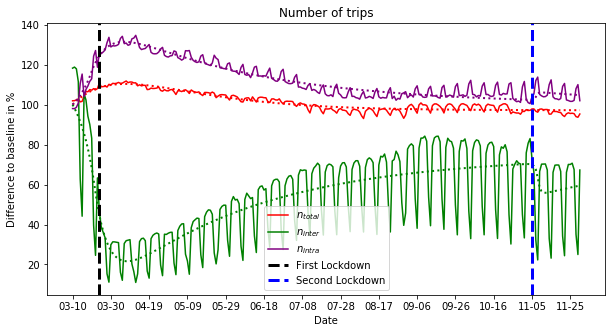

In [39]:
## UNTIL SUMMER
########################
ls_n_total = select_model(results['n_total'],n_total_lscc,'n_total')

##############################
# Fit model to n_total_inter #
##############################

ls_n_total_inter = select_model(results['n_total_inter'],n_total_inter_lscc,'n_total_inter')

##############################
# Fit model to n_total_intra #
##############################

ls_n_total_intra = select_model(results['n_total_intra'],n_total_intra_lscc,'n_total_intra')

# ##############
# Plot curves #
# ##############

x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))

ax.plot(100*results['n_total']/n_total_lscc,label=r'$n_{total}$',color = 'red')
ax.plot(x_days, 100*ls_n_total.eval(ls_n_total.params, x=x_days),linestyle = ':', color = 'red',linewidth=2)
ax.plot(100*results['n_total_inter']/n_total_inter_lscc,label=r'$n_{inter}$',color='green')
ax.plot(x_days, 100*ls_n_total_inter.eval(ls_n_total_inter.params, x=x_days),linestyle = ':', color = 'green',linewidth=2)
ax.plot(100*results['n_total_intra']/n_total_intra_lscc,label=r'$n_{intra}$',color='purple')
ax.plot(x_days, 100*ls_n_total_intra.eval(ls_n_total_intra.params, x=x_days),linestyle = ':', color = 'purple',linewidth=2)

ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Number of trips')

ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)
ax.legend(loc=8,frameon = True)
plt.show()


fig.savefig(root_figure+'/Timeseries_lscc'+'/days_trips_symmetric.pdf', dpi=fig.dpi,bbox_inches='tight')



## Number and size of connected components

In [40]:
compute_n_components_again = False
if compute_n_components_again == True:
    n_nodes = len(networks[0].nodes)

    # Compute number of WCCs, SCCs and size of LWCC, LSCC
    n_wcc = []
    s_lwcc = []
    n_scc = []
    s_lscc = []

    for G in networks:
        n_wcc.append(nx.algorithms.components.number_weakly_connected_components(G))
        s_lwcc.append(len(max(nx.algorithms.components.weakly_connected_components(G), key=len)))
        n_scc.append(nx.algorithms.components.number_strongly_connected_components(G))
        s_lscc.append(len(max(nx.algorithms.components.strongly_connected_components(G), key=len)))

    # Store results in dataframe
    results['n_wcc'] = n_wcc
    results['s_lwcc'] = s_lwcc
    results['n_scc'] = n_scc
    results['s_lscc'] = s_lscc
    
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results.to_csv(root3)
    
else:
    root3 = root_results + '/Timeseries'+'/stats_daily_digraphs_lscc.cvs'
    results = pd.read_csv(root3)
    


In [41]:
# Compute baseline values
n_wcc_lscc = nx.algorithms.components.number_weakly_connected_components(lscc)
s_lwcc_lscc = len(max(nx.algorithms.components.weakly_connected_components(lscc), key=len))
n_scc_lscc = nx.algorithms.components.number_strongly_connected_components(lscc)
s_lscc_lscc = len(max(nx.algorithms.components.strongly_connected_components(lscc), key=len))

s_lwcc & CVRMSE = 0.53& BIC= -1532.8 and -1539.1& AIC= -1554.1 and -1564.0

s_lscc & CVRMSE = 0.652& BIC= -1492.6 and -1568.7& AIC= -1514.0 and -1593.7



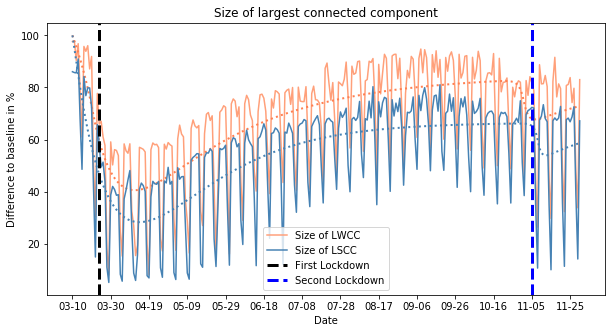

In [42]:
#######################
# Fit model to s_lwcc #
#######################

ls_s_lwcc = select_model(results['s_lwcc'],s_lwcc_lscc,'s_lwcc')
    
#######################
# Fit model to s_lscc #
#######################

ls_s_lscc = select_model(results['s_lscc'],s_lwcc_lscc,'s_lscc')


###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*results['s_lwcc']/s_lwcc_lscc,label='Size of LWCC',color = 'lightsalmon')
ax.plot(x_days, 100*ls_s_lwcc.eval(ls_s_lwcc.params, x=x_days),linestyle = ':', color = 'coral',linewidth = 2)
ax.plot(100*results['s_lscc']/s_lscc_lscc,label='Size of LSCC',color = 'steelblue')
ax.plot(x_days, 100*ls_s_lscc.eval(ls_s_lscc.params, x=x_days),linestyle = ':', color = 'steelblue',linewidth = 2)
ticks = range(0,n_days,20)

ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)

ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Size of largest connected component')
ax.legend(loc=8,frameon = True)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/s_components_symmetric.pdf', dpi=fig.dpi,bbox_inches='tight')

## Radius of Gyration

radius_of_gyration & CVRMSE = 0.48& BIC= -1567.4 and -1604.5& AIC= -1588.8 and -1629.4



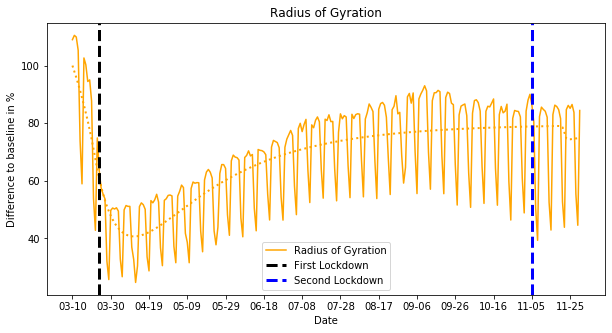

In [43]:
r_inter_median = pd.read_csv(root_results+'/r_inter_median.csv',index_col=0)
r_inter_median_lscc = 2473.306510441376
r_inter_median =r_inter_median.iloc[:,0]

#######################
# Fit model to s_lwcc #
#######################

ls_r_inter_median = select_model(r_inter_median,r_inter_median_lscc,'radius_of_gyration')
  
###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*r_inter_median/r_inter_median_lscc,label='Radius of Gyration',color = 'orange')
ax.plot(x_days, 100*ls_r_inter_median.eval(ls_r_inter_median.params, x=x_days),linestyle = ':', color = 'orange',linewidth=2)
ticks = range(0,n_days,20)

ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)

ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Radius of Gyration')
ax.legend(loc=8,frameon = True)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/rad_gyration_symmetric.pdf', dpi=fig.dpi,bbox_inches='tight')

radius_of_gyration & CVRMSE = 0.581& BIC= -1497.8 and -1619.5& AIC= -1519.2 and -1644.4



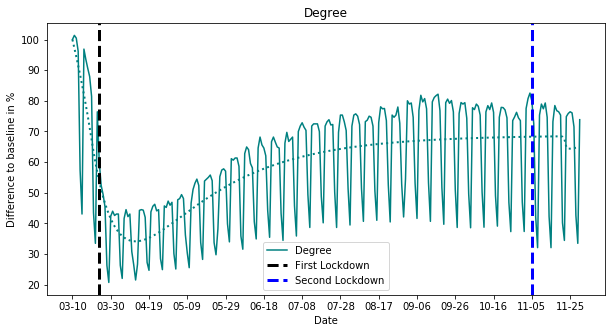

In [44]:
ls_degree_median = select_model(degree_median,degree_median_base,'radius_of_gyration')
  
###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*degree_median/degree_median_base,label='Degree',color = 'teal')
ax.plot(x_days, 100*ls_degree_median.eval(ls_degree_median.params, x=x_days),linestyle = ':', color = 'teal',linewidth=2)
ticks = range(0,n_days,20)

ax.axvline(x = lockdown_date_number,linestyle='dashed', color = 'black',label = 'First Lockdown',linewidth=3)
ax.axvline(x = second_lockdown_date_number,linestyle='dashed', color = 'blue',label = 'Second Lockdown',linewidth=3)

ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Degree')
ax.legend(loc=8,frameon = True)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/degree_symmetric.pdf', dpi=fig.dpi,bbox_inches='tight')

# Till Summer results and residuals 

In [45]:
# pre autumn results - fit with the first 60% of the data
percent = 0.6
summer_cut = int(percent*len(results['n_total']))
results_ps = results.loc[:summer_cut,:]

In [46]:
mod = lmfit.Model(responsed)

# Define parameters
params = lmfit.Parameters()
params.add('alpha', value=1)
params.add('beta', value=0.01, min=0.00001)
params.add('lamb', value=0.1, min=0.00001)
params.add('m', value=0)

## Number of trips

n_total & CVRMSE = 0.091& BIC= -1232.5 and -1515.7& AIC= -1241.6 and -1527.8

n_total_inter & CVRMSE = 0.707& BIC= -862.6 and -873.7& AIC= -871.7 and -885.9

n_total_intra & CVRMSE = 0.125& BIC= -1233.2 and -1246.2& AIC= -1242.3 and -1258.3



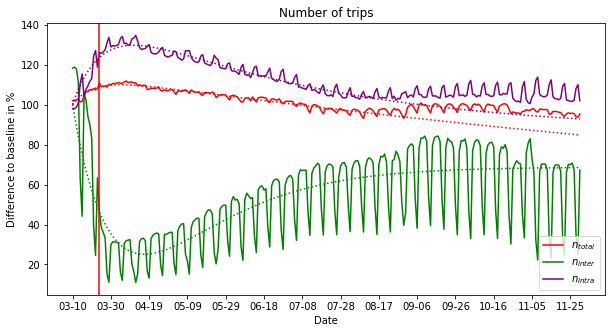

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [47]:
## UNTIL SUMMER
########################
ls_n_total = select_model(results_ps['n_total'],n_total_lscc,'n_total')

##############################
# Fit model to n_total_inter #
##############################

ls_n_total_inter = select_model(results_ps['n_total_inter'],n_total_inter_lscc,'n_total_inter')

##############################
# Fit model to n_total_intra #
##############################

ls_n_total_intra = select_model(results_ps['n_total_intra'],n_total_intra_lscc,'n_total_intra')

# ##############
# Plot curves #
# ##############

x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))

ax.plot(100*results['n_total']/n_total_lscc,label=r'$n_{total}$',color = 'red')
ax.plot(x_days, 100*ls_n_total.eval(ls_n_total.params, x=x_days),linestyle = ':', color = 'red')
ax.plot(100*results['n_total_inter']/n_total_inter_lscc,label=r'$n_{inter}$',color='green')
ax.plot(x_days, 100*ls_n_total_inter.eval(ls_n_total_inter.params, x=x_days),linestyle = ':', color = 'green')
ax.plot(100*results['n_total_intra']/n_total_intra_lscc,label=r'$n_{intra}$',color='purple')
ax.plot(x_days, 100*ls_n_total_intra.eval(ls_n_total_intra.params, x=x_days),linestyle = ':', color = 'purple')
ax.axvline(x = lockdown_date_number, color = 'red')
ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Number of trips')
ax.legend(loc=4,frameon = True)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/days_trips_pre_summer.eps', dpi=fig.dpi,bbox_inches='tight')

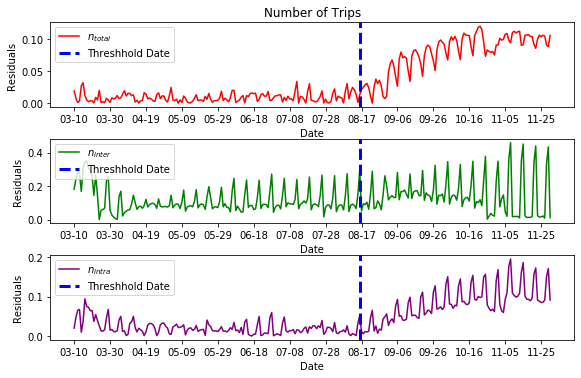

In [48]:
# plot residuals

fig, ax = plt.subplots(3,figsize =(8,5))

fig.tight_layout()
ax[0].plot(x_days,abs(results['n_total']/n_total_lscc-ls_n_total.eval(ls_n_total.params, x=x_days)),label=r'$n_{total}$',color = 'red')
ax[1].plot(x_days,abs(results['n_total_inter']/n_total_inter_lscc-ls_n_total_inter.eval(ls_n_total_inter.params, x=x_days)),label=r'$n_{inter}$',color = 'green')
ax[2].plot(x_days,abs(results['n_total_intra']/n_total_intra_lscc-ls_n_total_intra.eval(ls_n_total_intra.params, x=x_days)),label=r'$n_{intra}$',color = 'purple')

ax[0].set(xticks = ticks, xticklabels = days_dm[ticks],
      xlabel = 'Date',title = 'Number of Trips',ylabel = 'Residuals')
ax[0].axvline(x = summer_cut,linestyle='dashed', color = 'blue',label = 'Threshhold Date',linewidth=3)
ax[0].legend()

ax[1].set(xticks = ticks, xticklabels = days_dm[ticks],
      xlabel = 'Date',ylabel = 'Residuals')
ax[1].axvline(x = summer_cut,linestyle='dashed', color = 'blue',label = 'Threshhold Date',linewidth=3)
ax[1].legend(loc = 2)

ax[2].set(xticks = ticks, xticklabels = days_dm[ticks], 
      xlabel = 'Date',ylabel = 'Residuals')
ax[2].axvline(x = summer_cut,linestyle='dashed', color = 'blue',label = 'Threshhold Date',linewidth=3)
ax[2].legend()

#fig.suptitle('Number of Trips',size =14)

plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/days_trips_residuals.pdf', dpi=fig.dpi,bbox_inches='tight')

## Components

In [49]:
# pre summer results - use first 60% of the data
percent = 0.6
summer_cut = int(percent*len(results['n_total']))
results_ps = results.loc[:summer_cut,:]

s_lwcc & CVRMSE = 0.596& BIC= -886.5 and -883.9& AIC= -895.6 and -896.0

s_lscc & CVRMSE = 0.748& BIC= -920.2 and -925.1& AIC= -929.3 and -937.3



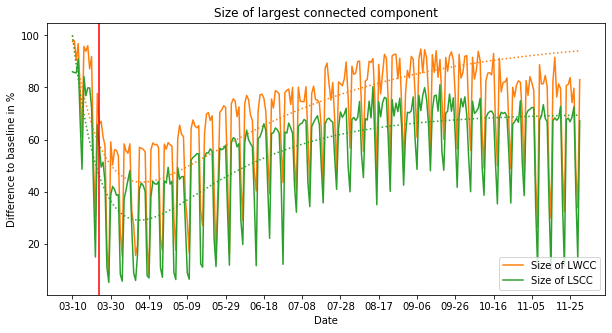

In [50]:
#######################
# Fit model to s_lwcc #
#######################

ls_s_lwcc = select_model(results_ps['s_lwcc'],s_lwcc_lscc,'s_lwcc')
    
#######################
# Fit model to s_lscc #
#######################

ls_s_lscc = select_model(results_ps['s_lscc'],s_lwcc_lscc,'s_lscc')


###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*results['s_lwcc']/s_lwcc_lscc,label='Size of LWCC',color = 'C1')
ax.plot(x_days, 100*ls_s_lwcc.eval(ls_s_lwcc.params, x=x_days),linestyle = ':', color = 'C1')
ax.plot(100*results['s_lscc']/s_lscc_lscc,label='Size of LSCC',color = 'C2')
ax.plot(x_days, 100*ls_s_lscc.eval(ls_s_lscc.params, x=x_days),linestyle = ':', color = 'C2')
ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number, color = 'red')
ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Size of largest connected component')
ax.legend(loc=4,frameon = True)
plt.show()




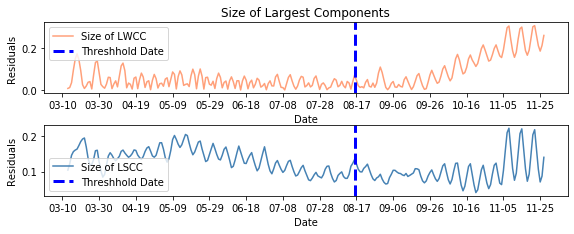

In [51]:
#plot residuals

fig, ax = plt.subplots(2,figsize =(8,3))
fig.tight_layout()

lowess = sm.nonparametric.lowess

y1 = abs(results['s_lwcc']/s_lwcc_lscc)
y1 = np.roll(np.asarray(y1.rolling(window = 7, win_type='triang').mean()),-3)

#print(ls_s_lwcc.eval(ls_s_lwcc.params, x=x_days))
y1 = abs(y1-ls_s_lwcc.eval(ls_s_lwcc.params, x=x_days))

x1 = range(0,len(y1),1)     
z1 = lowess(y1,x1)[:,1]


ax[0].plot(y1,label='Size of LWCC',color = 'lightsalmon')
#ax[0].plot(z1,'.-',color = 'coral')
ax[0].axvline(x = summer_cut,linestyle='dashed', color = 'blue',label = 'Threshhold Date',linewidth=3)
ax[0].set(xticks = ticks, xticklabels = days_dm[ticks], 
      xlabel = 'Date',ylabel = 'Residuals',title = 'Size of Largest Components')
ax[0].legend(loc = 2)

y2 = abs(results['s_lscc']/s_lscc_lscc-ls_s_lscc.eval(ls_s_lscc.params, x=x_days))
y2 = np.roll(np.asarray(y2.rolling(window = 7, win_type='triang').mean()),-3)
         
x2 = range(0,len(y2),1)     
z2 = lowess(y2,x2)[:,1]
         
ax[1].plot(y2,label='Size of LSCC',color = 'steelblue')
ax[1].axvline(x = summer_cut,linestyle='dashed', color = 'blue',label = 'Threshhold Date',linewidth=3)
ax[1].set(xticks = ticks, xticklabels = days_dm[ticks], 
      xlabel = 'Date',ylabel = 'Residuals')
#ax[1].plot(z2,color = 'steelblue')
ax[1].legend(loc = 3)

           
fig.savefig(root_figure+'/Timeseries_lscc'+'/s_components_residuals.pdf', dpi=fig.dpi,bbox_inches='tight')

## Degree and Radius of gyration

In [52]:
#pre summer results
percent = 0.6
summer_cut = int(percent*len(results['n_total']))
results_ps = results.loc[:summer_cut,:]

radius_of_gyration & CVRMSE = 0.504& BIC= -929.4 and -933.1& AIC= -938.4 and -945.2

radius_of_gyration & CVRMSE = 0.583& BIC= -1426.3 and -1610.4& AIC= -1437.0 and -1624.6



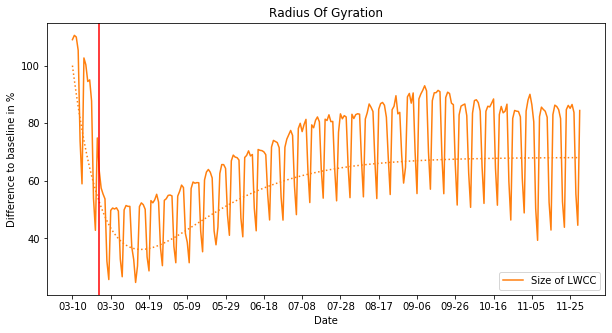

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [53]:
r_inter_median = pd.read_csv(root_results+'/r_inter_median.csv',index_col=0)
r_inter_median_lscc = 2473.306510441376
r_inter_median =r_inter_median.iloc[:,0]

percent = 0.6
summer_cut = int(percent*len(r_inter_median))
r_inter_median_ps = r_inter_median[:summer_cut]

#######################
# Fit model to s_lwcc #
#######################

ls_r_inter_median = select_model(r_inter_median_ps,r_inter_median_lscc,'radius_of_gyration')

### degree

degree_median_df = pd.read_csv(root_results+'/degree_median.csv',index_col=0) 

degree_median = degree_median_df.iloc[:,0]
degree_median_base = degree_median[0]

ls_r_inter_median = select_model(degree_median,degree_median_base,'radius_of_gyration')
  

###############
# Plot curves #
###############

# Plot
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,5))
ax.plot(100*r_inter_median/r_inter_median_lscc,label='Size of LWCC',color = 'C1')
ax.plot(x_days, 100*ls_r_inter_median.eval(ls_r_inter_median.params, x=x_days),linestyle = ':', color = 'C1')
ticks = range(0,n_days,20)
ax.axvline(x = lockdown_date_number, color = 'red')
ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Difference to baseline in %',
      xlabel = 'Date',title='Radius Of Gyration')
ax.legend(loc=4,frameon = True)
plt.show()

fig.savefig(root_figure+'/Timeseries_lscc'+'/rad_gyration.eps', dpi=fig.dpi,bbox_inches='tight')

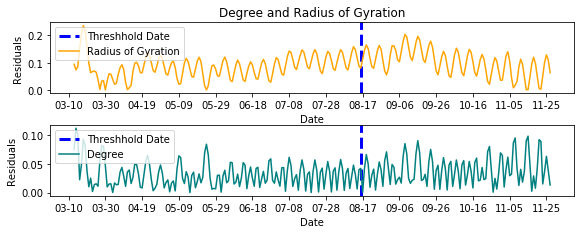

In [54]:
#plot residuals 

fig, ax = plt.subplots(2,figsize =(8,3))
fig.tight_layout()

lowess = sm.nonparametric.lowess

y1 = abs(r_inter_median/r_inter_median_lscc)
y1 = np.roll(np.asarray(y1.rolling(window = 7, win_type='triang').mean()),-3)

#print(ls_s_lwcc.eval(ls_s_lwcc.params, x=x_days))
y1 = abs(y1-ls_r_inter_median.eval(ls_r_inter_median.params, x=x_days))

x1 = range(0,len(y1),1)     
z1 = lowess(y1,x1)[:,1]

ax[0].axvline(x = summer_cut,linestyle='dashed', color = 'blue',label = 'Threshhold Date',linewidth=3)
ax[0].set(xticks = ticks, xticklabels = days_dm[ticks], 
      xlabel = 'Date',ylabel = 'Residuals',title='Degree and Radius of Gyration')
ax[0].plot(y1,label='Radius of Gyration',color = 'orange')
#ax[0].plot(z1,color = 'red')
ax[0].legend()



y2 = abs(degree_median/degree_median_base)
y2 = np.roll(np.asarray(y2.rolling(window = 7, win_type='triang').mean()),-3)

#print(ls_s_lwcc.eval(ls_s_lwcc.params, x=x_days))
y2 = abs(y2-ls_degree_median.eval(ls_degree_median.params, x=x_days))

x2 = range(0,len(y2),1)     
z2 = lowess(y2,x2)[:,1]

ax[1].axvline(x = summer_cut,linestyle='dashed', color = 'blue',label = 'Threshhold Date',linewidth=3)
ax[1].set(xticks = ticks, xticklabels = days_dm[ticks], 
      xlabel = 'Date',ylabel = 'Residuals')
ax[1].plot(y2,label='Degree',color = 'teal')
#ax[1].plot(z1,color = 'teal')
ax[1].legend()

fig.savefig(root_figure+'/Timeseries_lscc'+'/degree_rad_residuals.pdf', dpi=fig.dpi,bbox_inches='tight')